### Train with Unet

In [ ]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import create_validation_dirs, show_predictions
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random Train and Validation Set

In [ ]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [ ]:
create_validation_dirs(main_path, full_path, 0.90)

### Training

In [ ]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'

In [ ]:
# Look at training images
image_mask_paths = get_image_onemask_paths(train_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

In [ ]:
# Look at validation images
image_mask_paths = get_image_onemask_paths(valid_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

### Training

In [159]:
def train_augment(image, mask, index, sz = 256):        
    # do some data augmentation
    image, mask = random_horizontal_flip_transform2(image, mask)
    image, mask = random_vertical_flip_transform2(image, mask)
    #image, mask = random_rotate_transform2(image, mask)
    #image, mask = random_crop_resize2(image, mask, 0.1)
    
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    
    # normalize pixel intensities 
    # get dimensions right
    image = (image.transpose((2,0,1))) / 255 #shift channel axis to axis 0 and normalize
    mask = mask[None, :] / 255 # create binary mask
    
    return image.astype(np.float64), mask.astype(np.float64), index

def valid_augment(image, mask, index, sz = 256):        
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    
    # normalize pixel intensities 
    # get dimensions right
    image = (image.transpose((2,0,1))) / 255 #shift channel axis to axis 0 and normalize
    mask = mask[None, :] / 255 # create binary mask
    
    return image.astype(np.float64), mask.astype(np.float64), index

def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [162]:
# create trainloader
trn_ds = NucleiDataset('../data/ds_bowl_2018/dummy/', transform=valid_augment, mode='train')
trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=False)
# create validloader
val_ds = NucleiDataset('../data/ds_bowl_2018/dummy/', transform=valid_augment, mode='valid')
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False)
# create testloader
test_ds = NucleiDataset('../data/ds_bowl_2018/dummy/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [140]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=1).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters(), lr=0.1)
#criterion
crit = BCELoss2d()

In [141]:
# init classifier
classifier = NucleiClassifier(net, 1000)

In [144]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer,crit=crit, epochs=10, threshold=0.5)

Epoch: 11
Training : [0.0834],Validation : [4.1881]
Epoch: 12
Training : [0.0825],Validation : [1.7493]
Epoch: 13
Training : [0.0815],Validation : [0.773]
Epoch: 14
Training : [0.0807],Validation : [0.4075]
Epoch: 15
Training : [0.0798],Validation : [0.2456]
Epoch: 16
Training : [0.0791],Validation : [0.1738]
Epoch: 17
Training : [0.0775],Validation : [0.1321]
Epoch: 18
Training : [0.0764],Validation : [0.1104]
Epoch: 19
Training : [0.0751],Validation : [0.096]
Epoch: 20
Training : [0.0737],Validation : [0.0873]


In [ ]:
classifier.save_model('../data/ds_bowl_2018/models/unet256_model50', '../data/ds_bowl_2018/models/unet256_optim50')

### Visualize Evaluation

		 Image 					 Mask 				 Predicted Mask


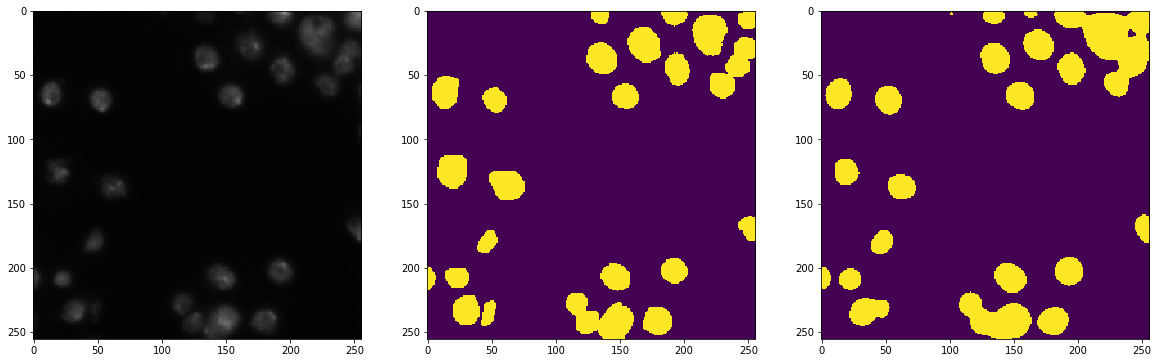

In [145]:
show_predictions(trn_dl, classifier, 0.5, 1)

		 Image 					 Mask 				 Predicted Mask


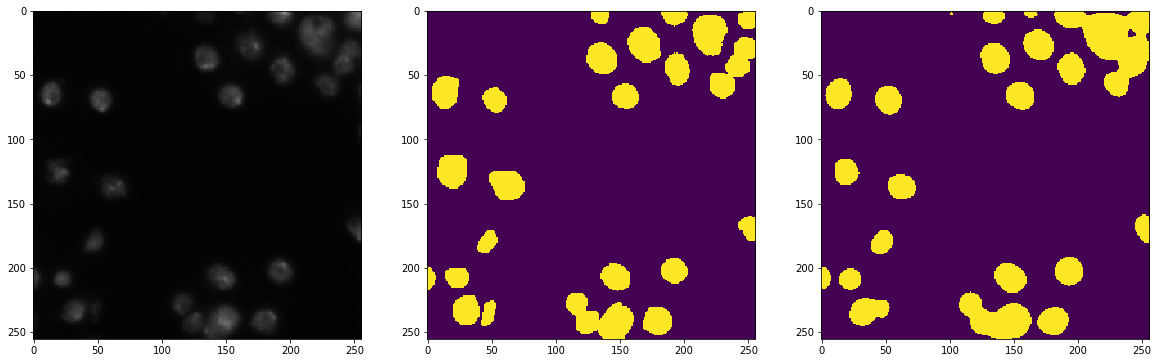

In [146]:
show_predictions(val_dl, classifier, 0.5, n=10)

### Make Predictions

In [222]:
def predict_and_submit(classifier, testloader):
    preds = classifier.predict(test_dl)
    
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ds.image_dirs):
        id_ = id_.split('/')[-2]
        rle = list(prob_to_rles(preds[n][0,0]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    return sub

In [224]:
sub_df = predict_and_submit(classifier, test_dl)

In [ ]:
sub_df.to_csv('../data/ds_bowl_2018/submissions/unet_basic.csv', index=False)

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink('../data/ds_bowl_2018/submissions/unet_basic.csv')